In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import pickle
import PIL
import torch
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [23]:
# Set Seed
torch.manual_seed(11)
np.random.seed(11)

In [24]:
path ='../Data'
save_path = '../Preprocessed_Data'

In [25]:
def load_embeddings(file_name):
    with open(save_path + '/' + file_name, 'rb') as f:
        embeddings = pickle.load(f)
    return embeddings

train_bert_embeddings = load_embeddings('train_bert_embeddings.pkl')
test_bert_embeddings = load_embeddings('test_bert_embeddings.pkl')
dev_bert_embeddings = load_embeddings('dev_bert_embeddings.pkl')

train_df = pd.read_csv(save_path + '/df_train.csv')
test_df = pd.read_csv(save_path + '/df_test_seen.csv')
dev_df = pd.read_csv(save_path + '/df_dev_seen.csv')

In [26]:
# Convert tensors to numpy arrays
train_bert_embeddings = np.array([i.numpy() for i in train_bert_embeddings])
test_bert_embeddings = np.array([i.numpy() for i in test_bert_embeddings])
dev_bert_embeddings = np.array([i.numpy() for i in dev_bert_embeddings])

In [27]:
type(train_bert_embeddings), type(train_bert_embeddings[0])

(numpy.ndarray, numpy.ndarray)

In [28]:
train_bert_embeddings.shape, train_bert_embeddings[0].shape

((4192, 768), (768,))

In [29]:
# concat resnet and bert embeddings
train_embeddings = train_bert_embeddings
test_embeddings = test_bert_embeddings
dev_embeddings = dev_bert_embeddings

In [30]:
train_labels = train_df['label'].values
test_labels = test_df['label'].values
dev_labels = dev_df['label'].values

In [31]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Define a custom PyTorch dataset for the ResNet embeddings and labels
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.features[idx]).float()
        y = torch.tensor(self.labels[idx]).long()
        return x, y


# Create a custom PyTorch dataset for the train set ResNet embeddings and labels
train_dataset = MyDataset(train_embeddings, train_labels)

# Create a custom PyTorch dataset for the test set ResNet embeddings and labels
test_dataset = MyDataset(test_embeddings, test_labels)

# Create a custom PyTorch dataset for the dev set ResNet embeddings and labels
dev_dataset = MyDataset(dev_embeddings, dev_labels)

# Create a PyTorch DataLoader for the train set with a batch size of 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create a PyTorch DataLoader for the test set with a batch size of 32
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create a PyTorch DataLoader for the dev set with a batch size of 32
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
    def get_presoftmax_values(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Define the train function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy

# Define the validation function
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

# Set the device to use for training the model (e.g. CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model, optimizer, and loss criterion
model = MLPClassifier(input_size=768, hidden_size=256, output_size=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Train the model and log the training and validation losses and accuracies
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
best_val_accuracy_epoch = 0

for epoch in range(1, num_epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
    val_loss, val_accuracy = validate(model, device, dev_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch}: Train Loss={train_loss:.6f}, Train Accuracy={train_accuracy:.2f}%, Val Loss={val_loss:.6f}, Val Accuracy={val_accuracy:.2f}%")
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_val_accuracy_epoch = epoch
        torch.save(model.state_dict(), "text_model.pt")

Epoch 1: Train Loss=0.020098, Train Accuracy=65.10%, Val Loss=0.023334, Val Accuracy=51.41%
Epoch 2: Train Loss=0.018872, Train Accuracy=69.06%, Val Loss=0.023364, Val Accuracy=53.82%
Epoch 3: Train Loss=0.018213, Train Accuracy=71.64%, Val Loss=0.022168, Val Accuracy=57.03%
Epoch 4: Train Loss=0.017847, Train Accuracy=73.09%, Val Loss=0.022604, Val Accuracy=56.63%
Epoch 5: Train Loss=0.017533, Train Accuracy=73.54%, Val Loss=0.023342, Val Accuracy=54.22%
Epoch 6: Train Loss=0.017366, Train Accuracy=74.09%, Val Loss=0.022556, Val Accuracy=55.82%
Epoch 7: Train Loss=0.017043, Train Accuracy=76.38%, Val Loss=0.023343, Val Accuracy=53.82%
Epoch 8: Train Loss=0.016921, Train Accuracy=76.19%, Val Loss=0.023137, Val Accuracy=54.22%
Epoch 9: Train Loss=0.016661, Train Accuracy=77.15%, Val Loss=0.023336, Val Accuracy=53.82%
Epoch 10: Train Loss=0.016393, Train Accuracy=78.34%, Val Loss=0.023105, Val Accuracy=55.42%
Epoch 11: Train Loss=0.016309, Train Accuracy=78.77%, Val Loss=0.023560, Val Ac

In [33]:
model = MLPClassifier(input_size=768, hidden_size=256, output_size=2).to(device)
model.load_state_dict(torch.load("text_model.pt"))

<All keys matched successfully>

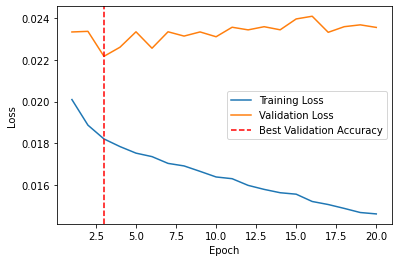

In [34]:
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
# Add a vertical line at the epoch with the best validation accuracy
plt.axvline(x=best_val_accuracy_epoch, color="red", linestyle="--", label="Best Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

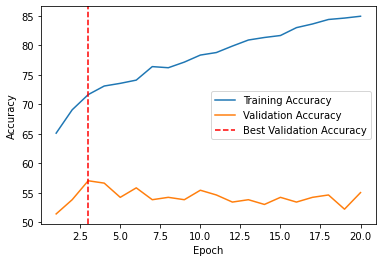

In [35]:
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
# Add a vertical line at the epoch with the best validation accuracy
plt.axvline(x=best_val_accuracy_epoch, color="red", linestyle="--", label="Best Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [36]:
# Predict the labels for the test set
model.eval()
test_predictions = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        test_predictions.extend(pred.tolist())

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, test_predictions))

accuracy = 0
for i in range(len(test_predictions)):
    if test_predictions[i] == test_labels[i]:
        accuracy += 1
print("Test Accuracy: ", accuracy/len(test_predictions))

              precision    recall  f1-score   support

           0       0.53      0.75      0.62       221
           1       0.61      0.38      0.47       233

    accuracy                           0.56       454
   macro avg       0.57      0.56      0.55       454
weighted avg       0.57      0.56      0.54       454

Test Accuracy:  0.5594713656387665


## TSNE Vis

In [37]:
import random
random.seed(42)
# sample 100 indexes where value is 0
zero_indexes = random.sample(list(np.where(test_labels == 0)[0]), 100)
random.seed(42)
# sample 100 indexes where value is 1
one_indexes = random.sample(list(np.where(test_labels == 1)[0]), 100)

In [38]:
# get the embeddings for the 100 indexes where value is 0
zero_embeddings = [test_embeddings[i] for i in zero_indexes]
# get the embeddings for the 100 indexes where value is 1
one_embeddings = [test_embeddings[i] for i in one_indexes]

In [39]:
# Get the penultimate layer values for the 100 indexes where value is 0
zero_penultimate = []
for i in range(len(zero_embeddings)):
    zero_penultimate.append(model.get_presoftmax_values(torch.tensor(zero_embeddings[i]).to(device)).tolist())

# Get the penultimate layer values for the 100 indexes where value is 1
one_penultimate = []
for i in range(len(one_embeddings)):
    one_penultimate.append(model.get_presoftmax_values(torch.tensor(one_embeddings[i]).to(device)).tolist())

In [40]:
# TSNE for combined embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine the embeddings and labels
combined_embeddings = zero_embeddings + one_embeddings
combined_labels = [0] * len(zero_embeddings) + [1] * len(one_embeddings)

# Reduce the dimensionality of the embeddings using TSNE
tsne = TSNE(n_components=2, random_state=42)

# Get the embeddings in 2D
embeddings_2d = tsne.fit_transform(combined_embeddings)

# Create a dataframe with the embeddings and labels
df = pd.DataFrame(embeddings_2d, columns=["x", "y"])
df["label"] = combined_labels

# Plot using plotly
import plotly.express as px
fig = px.scatter(df, x="x", y="y", color="label")
fig.show()


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [41]:

# TSNE for penultimate layer values
# Combine the penultimate layer values and labels

combined_penultimate = zero_penultimate + one_penultimate
combined_labels = [0] * len(zero_penultimate) + [1] * len(one_penultimate)

# Reduce the dimensionality of the embeddings using TSNE
tsne = TSNE(n_components=2, random_state=42)

# Get the embeddings in 2D
embeddings_2d = tsne.fit_transform(combined_penultimate)

# Create a dataframe with the embeddings and labels
df = pd.DataFrame(embeddings_2d, columns=["x", "y"])
df["label"] = combined_labels

# Plot using plotly
import plotly.express as px
fig = px.scatter(df, x="x", y="y", color="label")
fig.show()
  

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [42]:

# TSNE for penultimate layer values
# Combine the penultimate layer values and labels

combined_penultimate = zero_penultimate + one_penultimate
combined_labels = [0] * len(zero_penultimate) + [1] * len(one_penultimate)

# Reduce the dimensionality of the embeddings using TSNE
tsne = TSNE(n_components=3, random_state=42)

# Get the embeddings in 3D
embeddings_3d = tsne.fit_transform(combined_penultimate)

# Create a dataframe with the embeddings and labels
df = pd.DataFrame(embeddings_3d, columns=["x", "y", "z"])
df["label"] = combined_labels

# Plot using plotly
import plotly.express as px
fig = px.scatter_3d(df, x="x", y="y", z="z", color="label")
fig.show()


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

